In [6]:
#! /usr/bin/env python

# PonyGE2
# Copyright (c) 2017 Michael Fenton, James McDermott,
#                    David Fagan, Stefan Forstenlechner,
#                    and Erik Hemberg
# Hereby licensed under the GNU GPL v3.
""" Python GE implementation """

from utilities.algorithm.general import check_python_version

check_python_version()
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from stats.stats import get_stats
from algorithm.parameters import params, set_params
import sys
import time
import numpy as np
np.set_printoptions(linewidth=150)
import random
import os
import pickle

from utilities.stats import trackers


In [43]:
file_path = f"./results_data/results_data_fold_2.pkl"

# Load the data
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

# Access the loaded data
crossover_rates = loaded_data['crossover_rates']
seeds = loaded_data['seeds']
test_results = loaded_data['test_results']
train_results = loaded_data['train_results']
test_evolution = loaded_data['test_evolution']
train_evolution = loaded_data['train_evolution']

#print(test_results[1][2])

print("Crossover rates:", crossover_rates)
print("Seeds:", seeds)
print("Test results shape:", test_results.shape)
print("Train results shape:", train_results.shape)
print("Test evolution shape:", test_evolution.shape)
print("Train evolution shape:", train_evolution.shape)


Crossover rates: [0.         0.16666667 0.33333333 0.5       ]
Seeds: [382848859 372844088  75509776]
Test results shape: (3, 4)
Train results shape: (3, 4)
Test evolution shape: (3, 4, 51)
Train evolution shape: (3, 4, 51)


In [42]:
print(seeds)

[382848859 372844088  75509776]


In [11]:
test_results.shape

(3, 4)

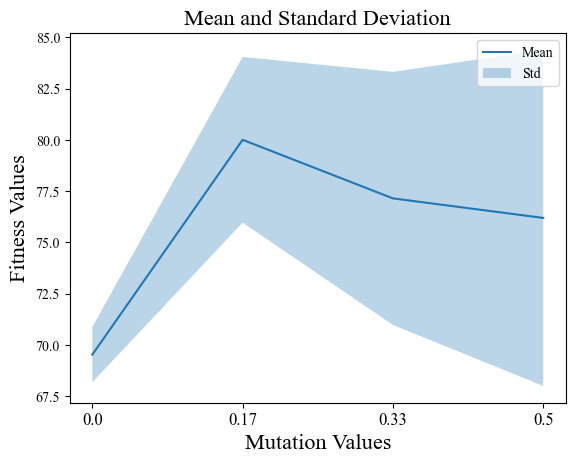

In [10]:
matplotlib.use('Qt5Agg')
%matplotlib inline


# Generate mutation values
mean = np.mean(test_results, axis = 0)
std = np.std(test_results, axis = 0)

# Plot mean and standard deviation
plt.plot(crossover_rates, mean, label="Mean")
plt.fill_between(crossover_rates, mean - std, mean + std, alpha=0.3, label="Std")

# Set axis labels and title
plt.xlabel("Mutation Values", fontsize=16)
plt.ylabel("Fitness Values", fontsize=16)
plt.title("Mean and Standard Deviation", fontsize=16)

# Set xticks to display actual values of mutation_values rounded to 2 decimal places
rounded_x = np.round(crossover_rates, 2)
plt.xticks(crossover_rates, rounded_x, fontsize = 12)

# Add legend and display the plot
plt.legend()
plt.show()


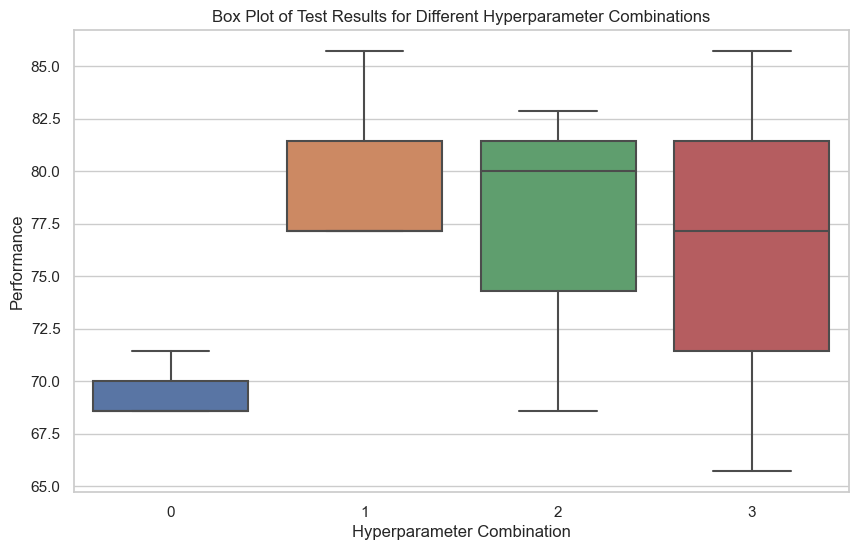

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_results is a 2D numpy array with shape (num_seeds, num_hyperparams)

# Calculate the average performance across seeds (axis 0)
avg_test_results = np.mean(test_results, axis=0)


# Set up the box plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Create the box plot
sns.boxplot(data=test_results)

# Set plot labels and title
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Performance')
plt.title('Box Plot of Test Results for Different Hyperparameter Combinations')

# Show the plot
plt.show()


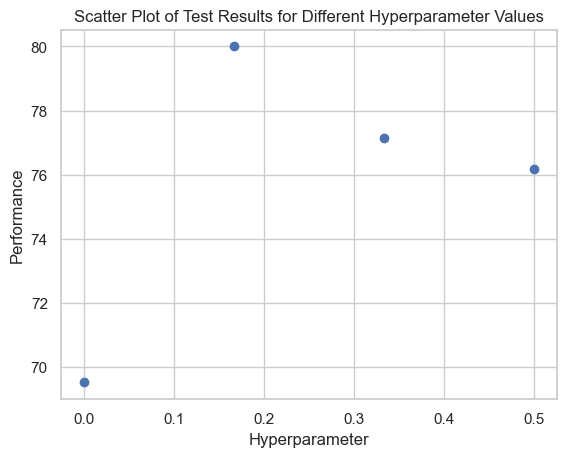

In [24]:
import matplotlib.pyplot as plt

# Assuming avg_test_results is a 1D numpy array with shape (num_hyperparams,)
# and hyperparam_values is a 1D numpy array with the hyperparameter values

# Create a scatter plot
plt.scatter(crossover_rates, avg_test_results)

# Set plot labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Performance')
plt.title('Scatter Plot of Test Results for Different Hyperparameter Values')

# Show the plot
plt.show()


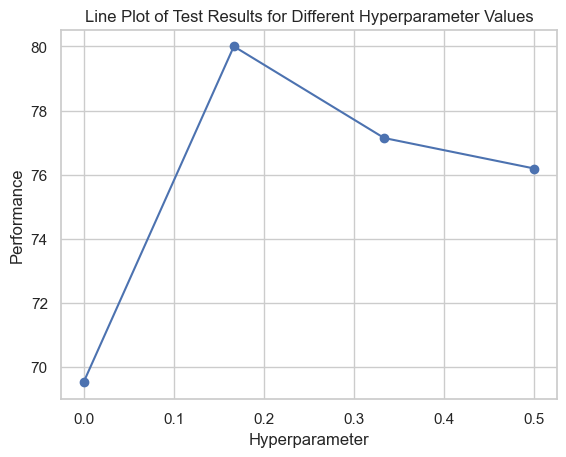

In [26]:
# Create a line plot
plt.plot(crossover_rates, avg_test_results, marker='o')

# Set plot labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Performance')
plt.title('Line Plot of Test Results for Different Hyperparameter Values')

# Show the plot
plt.show()


[65.70743405 66.42685851 66.90647482 67.62589928 67.62589928 67.86570743 67.86570743 68.34532374 69.54436451 70.98321343 71.22302158 71.22302158
 72.90167866 73.62110312 73.62110312 73.62110312 73.62110312 73.62110312 73.62110312 73.62110312 73.86091127 73.86091127 73.86091127 73.86091127
 73.86091127 73.86091127 74.10071942 74.58033573 74.58033573 74.82014388 74.82014388 75.05995204 75.05995204 75.05995204 75.05995204 75.05995204
 75.05995204 75.29976019 75.29976019 75.29976019 75.29976019 75.29976019 75.29976019 76.01918465 76.01918465 76.01918465 76.01918465 76.01918465
 76.01918465 76.01918465 76.01918465]


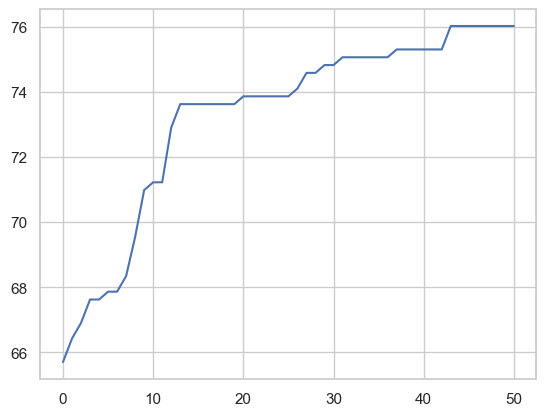

In [39]:

agg_train_evolution = np.mean(train_evolution, axis=0)
agg_train_evolution.shape

print(agg_train_evolution[0])


plt.plot(agg_train_evolution[0])
plt.show()